In [628]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
from Utils import *
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from Utils import performance

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.4f}'.format

In [629]:
tickers = get_sp500_tickers()
df = yf.download(tickers=tickers,period="4y",interval="1d",auto_adjust=True).reset_index()

[*********************100%***********************]  503 of 503 completed


In [630]:
df_close = pd.concat([df['Date'],df['Close']], axis=1)
df_close = df_close.set_index('Date')

# Find a portfolios in SP500 which are cointegrated
- Assume we want to construct a portfolios of <b>n stocks</b>, we want to find a portfolio such that the linear combination of all stocks price are stationary

- We use <b>Johensen Test</b> to test and find a possible cointegrated portfolios

- <b>Johensen Test</b> returns eigenvector and eigenvalues of the matrix $\prod$ from VECM models, where eigenvector represents the linear combination of the time series and eigenvalues represents magnitude of the cointegrating relationships

    - <b><i>res.lr2</i></b> is the test statistics, where <b><i>res.cvm</i></b> is the critical values for 90%/95%/99%

    - <b><i>res.eig</i></b> returns the eigenvalues whereas <b><i>res.evec</i></b> returns the eigenvectors, the first eigenvector is the one with highest eigenvector => we should use this as our portfolios

- <b>Taking log price seems to be easier to find cointegrated portfolios</b>
    - log prices are non-stationary whereas the log-returns (diff of $y_i - y_{i-1}$ are weak stationary)

In [631]:
n = 4
ports = []
ports_n = 100000

while len(ports) < ports_n:
    port = random.sample(tickers, n)
    ports.append(port)

ports_coint = []
ports_coint_vec = []

with tqdm(total=len(ports)) as pbar:
    for port in ports:
        px = df_close[port].values
        try:
            res = coint_johansen(np.log(px), det_order=0, k_ar_diff=1)
        except:
            # Error: SVD did not converge
            pbar.update(1)
            continue

        if sum(res.lr2 > res.cvm[:,-2]) == n:            
            ports_coint.append(port)
            ports_coint_vec.append(res.evec[:,0])
            print(f'#{len(ports_coint)}: {ports_coint[-1]}')
        pbar.update(1)    

 60%|█████▉    | 59754/100000 [00:46<00:29, 1366.74it/s]

#1: ['CLX', 'AVB', 'TDY', 'WELL']


 64%|██████▎   | 63605/100000 [00:49<00:27, 1307.47it/s]

#2: ['O', 'NSC', 'CMS', 'WEC']


100%|██████████| 100000/100000 [01:17<00:00, 1291.84it/s]


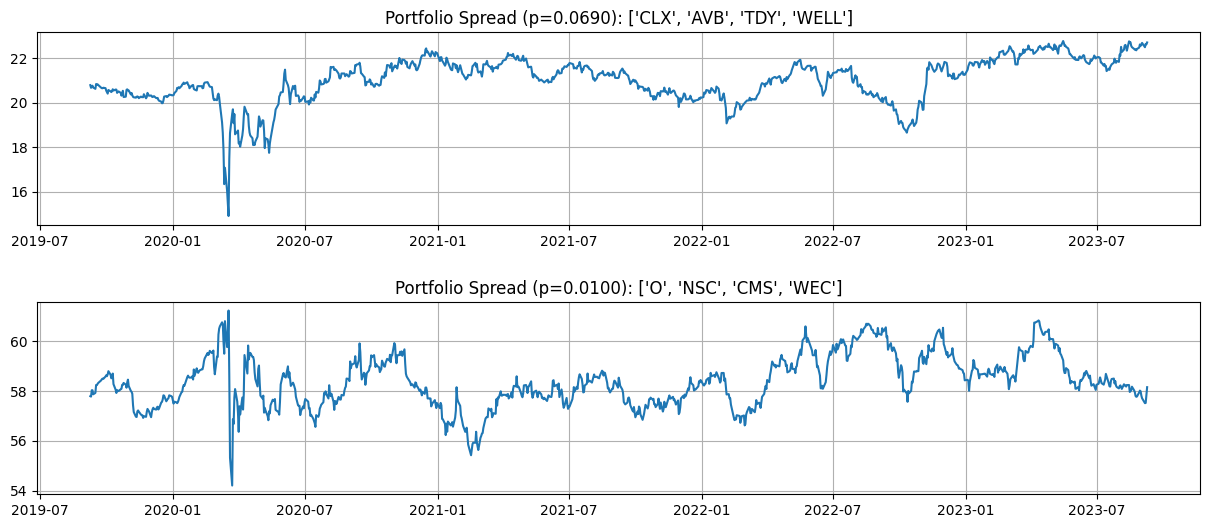

In [632]:
fig = plt.figure(figsize=(15,3*len(ports_coint)))
fig.subplots_adjust(hspace=0.4)
gs = GridSpec(len(ports_coint), 1)

for i, (port, port_vec) in enumerate(zip(ports_coint, ports_coint_vec)):
    ax = fig.add_subplot(gs[i])
    px = np.log(df_close[port])
    #px = df_close[port]
    spread = (px * port_vec).sum(axis=1)
    pvalue = adfuller(spread)[1]    

    ax.plot(spread)
    ax.grid()
    ax.set_title('Portfolio Spread (p={:.4f}): {}'.format(pvalue, port))

# Trading Strategy (in-sample)

$$Z_t = \sum_i ev_i * log(p_{it})$$
$$\hat Z_t = \frac{Z_t - E(Z_t)}{\sigma_{Z_t}}$$

where
- $ev_i$ is the eigenvectors

This is because the portfolios spread $\hat Z_t$ are stationary at zero, we expect the $\hat Z_t$ will follows mean-reversion whenever $\hat Z_t$ is fairly above 0 or below 0, hence, the strategy is simple, i.e.
- when $\hat Z_t \gt A$, sell the spread (and optionally close at 0)
- when $\hat Z_t \lt -A$, buy the spread (and optionally close at 0)

Therefore,

1. Normalize the eigenvector to weights, we can normalize such that all positive weights sum up to 1 (or negative weights sum up to 1)
    - $\hat v = v / \sum_i (v_i > 0) * v_i$
2. Trade the spread when
-  Long spread when $\hat Z_t \lt -n\sigma$
-  Short spread when $\hat Z_t \gt n\sigma$
- n could be between 1 and 2

In [634]:
# choose a portfolio to try
i = 0
port = ports_coint[i]
port_vec = ports_coint_vec[i]
spread = (np.log(df_close[port]) * port_vec).sum(axis=1)
spread_mean = np.mean(spread)
spread_std = np.std(spread)
spread_z = (spread - spread_mean)/spread_std

# normalized the weights
weights = port_vec.copy()
norm = sum(weights[weights > 0])
weights = weights / norm

[*********************100%***********************]  1 of 1 completed


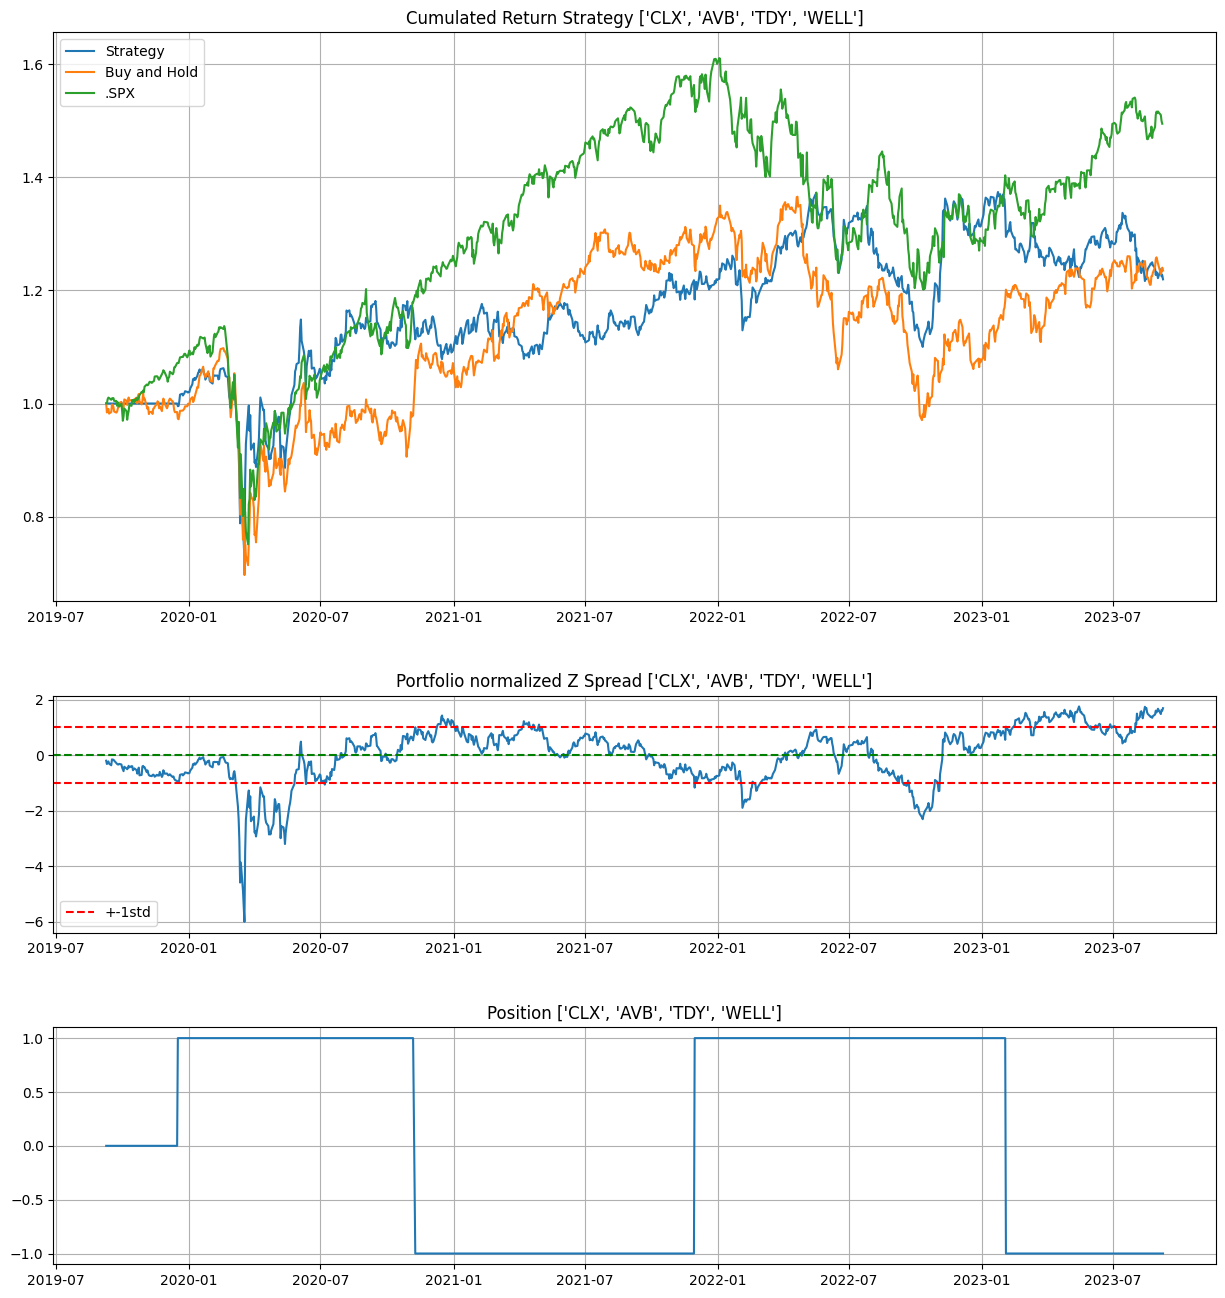

,strategy,cumulative_return,annualized_return,annualized_volatility,annualized_sharpe_ratio,maximum_drawdown
0,Strategy,1.2194,0.0724,0.2152,0.1715,-0.3167
1,SPX,1.4945,0.1268,0.2286,0.3998,-0.3392
2,buy_and_hold,1.2351,0.0843,0.2496,0.1958,-0.3653


In [635]:
signals = []
z_th = 1

for i, z in enumerate(spread_z):
    prev_z = z if i == 0 else spread_z[i-1]
    prev_signal = signals[-1] if len(signals) else 0

    if z < -z_th:
        signals.append(1)
    elif z > z_th:
        signals.append(-1)
    #elif z > 0 and prev_signal == 1:
    #    signals.append(0)
    #elif z < 0 and prev_signal == -1:
    #    signals.append(0)
    else:
        signals.append(prev_signal)

signals = np.array(signals)
positions = np.array([s * weights for s in signals])
px_return = df_close[port].pct_change().fillna(0)
dates = df_close.index
port_return = (positions * px_return).sum(axis=1)
port_return_cum = performance.cumulative_return(port_return)

fig = plt.figure(figsize=(15,16))
fig.subplots_adjust(hspace=0.4)
gs = GridSpec(4,1)

ax = fig.add_subplot(gs[0:2])
ax.plot(port_return_cum, label='Strategy')
ax.set_title('Cumulated Return Strategy {}'.format(port))
ax.grid()

# buy and hold as benchmark the portfolios
buy_and_hold_return = px_return.mean(axis=1)
buy_and_hold_return_cum = performance.cumulative_return(buy_and_hold_return)
ax.plot(buy_and_hold_return_cum, label='Buy and Hold')

# .SPX
spx = yf.download(
    tickers='^SPX', 
    start=min(df_close.index), 
    end=max(df_close.index), 
    interval="1d",auto_adjust=True).reset_index()
spx = spx.set_index('Date')
spx = spx['Close']
spx_return = spx.pct_change().fillna(0)
spx_return_cum = performance.cumulative_return(spx_return)
ax.plot(spx_return_cum, label='.SPX')
ax.legend(loc='upper left')

ax = fig.add_subplot(gs[2])
ax.plot(spread_z)
ax.set_title('Portfolio normalized Z Spread {}'.format(port))
ax.axhline(0, color='green', linestyle='--')
ax.axhline(z_th*spread_std, label=f"+-{z_th}std", color='red', linestyle='--')
ax.axhline(-z_th*spread_std, color='red', linestyle='--')
ax.grid()
ax.legend()

ax = fig.add_subplot(gs[3])
ax.plot(dates, signals)
ax.set_title('Position {}'.format(port))
ax.grid()
plt.show()

strat_perf = performance.performance_summary(port_return, 'Strategy')
spx_perf = performance.performance_summary(spx_return, 'SPX')
buy_and_hold = performance.performance_summary(buy_and_hold_return, 'buy_and_hold')

summary = pd.DataFrame([strat_perf, spx_perf, buy_and_hold])
display(summary)

# BackTesting (out-sample)

However, it is obviously that above approach has look-ahead bias. So we should split the training and testing period

- Training period: Using two years data to find a cointegrated portfolios and spreads
- Testing period: Execute the trading strategy based on the spread (use $w_t, E(\hat Z_t), \sigma_{\hat Z_t}$ from training periods)

In [636]:
def find_cointegrated_port(df_close, n, iter=100000):    
    print(f'finding cointegrated portfolios of {n} stocks......')
    ports = []    
    tickers = list(df_close.columns)

    while len(ports) < iter:
        port = random.sample(tickers, n)
        ports.append(port)

    ports_coint = []
    ports_coint_vec = []
    with tqdm(total=len(ports)) as pbar:
        for port in ports:
            px = df_close[port].values
            try:
                res = coint_johansen(np.log(px), det_order=0, k_ar_diff=1)
            except:
                # Error: SVD did not converge
                pbar.update(1)
                continue

            # 95% confidence
            if sum(res.lr2 > res.cvm[:,-2]) == n:            
                ports_coint.append(port)
                ports_coint_vec.append(res.evec[:,0])
                print(f'#{len(ports_coint)}: {ports_coint[-1]}')
            pbar.update(1)  

    return list(zip(ports_coint, ports_coint_vec))

def generate_signals(spread_z, z_th):
    signals = []    
    for i, z in enumerate(spread_z):         
        prev_signal = signals[-1] if len(signals) else 0
        if z < -z_th:
            signals.append(1)
        elif z > z_th:
            signals.append(-1)
        #elif z > 0 and prev_signal == 1:
        #    signals.append(0)
        #elif z < 0 and prev_signal == -1:
        #    signals.append(0)
        else:
            signals.append(prev_signal)
    return signals

def backtest_portfolios(df_close_train, df_close_test, port, z_th, in_sample=False):
    port_tickers, ev = port
    weights = ev / np.sum(ev[ev > 0])

    spread_train = (np.log(df_close_train[port_tickers]) * weights).sum(axis=1)    
    spread_mean = np.mean(spread_train)
    spread_std = np.std(spread_train)
    spread_z_train = (spread_train - spread_mean)/spread_std

    spread_test = (np.log(df_close_test[port_tickers]) * weights).sum(axis=1)
    spread_z_test = (spread_test - spread_mean)/spread_std

    # backtesting training data (look-ahead bias)
    if in_sample:
        spread_z_test = spread_z_train
        df_close_test = df_close_train

    signals = generate_signals(spread_z_test, z_th)
    positions = np.array([s * weights for s in signals])

    px_return = df_close_test[port_tickers].pct_change().fillna(0)
    dates = df_close_test.index
    port_return = (positions * px_return).sum(axis=1)
    port_return_cum = performance.cumulative_return(port_return)

    # summarize the performance
    fig = plt.figure(figsize=(15,10))
    fig.subplots_adjust(hspace=0.4)
    fig.suptitle(f'{"In Sample" if in_sample else "Out Sample"} - {port_tickers}', y=0.95, fontsize=20)

    gs = GridSpec(4,1)

    ax = fig.add_subplot(gs[0:2])
    ax.plot(port_return_cum, label='Strategy')
    ax.set_title('Cumulated Return Strategy')
    ax.grid()

    # buy and hold as benchmark the portfolios
    buy_and_hold_return = px_return.mean(axis=1)
    buy_and_hold_return_cum = performance.cumulative_return(buy_and_hold_return)
    ax.plot(buy_and_hold_return_cum, label='Buy and Hold')

    # .SPX
    spx = yf.download(
        tickers='^SPX', 
        start=min(df_close_test.index), 
        end=max(df_close_test.index), 
        interval="1d",auto_adjust=True).reset_index()
    spx = spx.set_index('Date')
    spx = spx['Close']
    spx_return = spx.pct_change().fillna(0)
    spx_return_cum = performance.cumulative_return(spx_return)
    ax.plot(spx_return_cum, label='.SPX')
    ax.legend(loc='upper left')

    ax = fig.add_subplot(gs[2])
    ax.plot(spread_z_test)
    ax.set_title('Portfolio normalized Z Spread')
    ax.axhline(0, color='green', linestyle='--')
    ax.axhline(z_th, label=f"+-{z_th}std", color='red', linestyle='--')
    ax.axhline(-z_th, color='red', linestyle='--')
    ax.grid()
    ax.legend()

    ax = fig.add_subplot(gs[3])
    ax.plot(dates, signals)
    ax.set_title('Position')
    ax.grid()
    plt.show()

    strat_perf = performance.performance_summary(port_return, 'Strategy')
    spx_perf = performance.performance_summary(spx_return, 'SPX')
    buy_and_hold = performance.performance_summary(buy_and_hold_return, 'buy_and_hold')

    summary = pd.DataFrame([strat_perf, spx_perf, buy_and_hold])
    display(summary)   

In [637]:
training_periods = 252*4
testing_periods = 120
start_date = datetime.today() - BDay(training_periods + testing_periods)

tickers = get_sp500_tickers()
df = yf.download(tickers=tickers, start=start_date,interval="1d",auto_adjust=True).reset_index()


[*********************100%***********************]  503 of 503 completed


In [639]:
df_close = pd.concat([df['Date'],df['Close']], axis=1)
df_close = df_close.set_index('Date')
df_close_train = df_close[:start_date + BDay(training_periods)]
df_close_test = df_close[start_date + BDay(training_periods):]

In [640]:
n = 4
ports = find_cointegrated_port(df_close_train, n)

finding cointegrated portfolios of 4 stocks......


  2%|▏         | 2066/100000 [00:01<01:12, 1343.76it/s]

#1: ['DHI', 'O', 'ETR', 'V']


 34%|███▎      | 33540/100000 [00:25<00:47, 1411.39it/s]

#2: ['O', 'MA', 'BDX', 'VTR']


100%|██████████| 100000/100000 [01:14<00:00, 1339.52it/s]


[*********************100%***********************]  1 of 1 completed


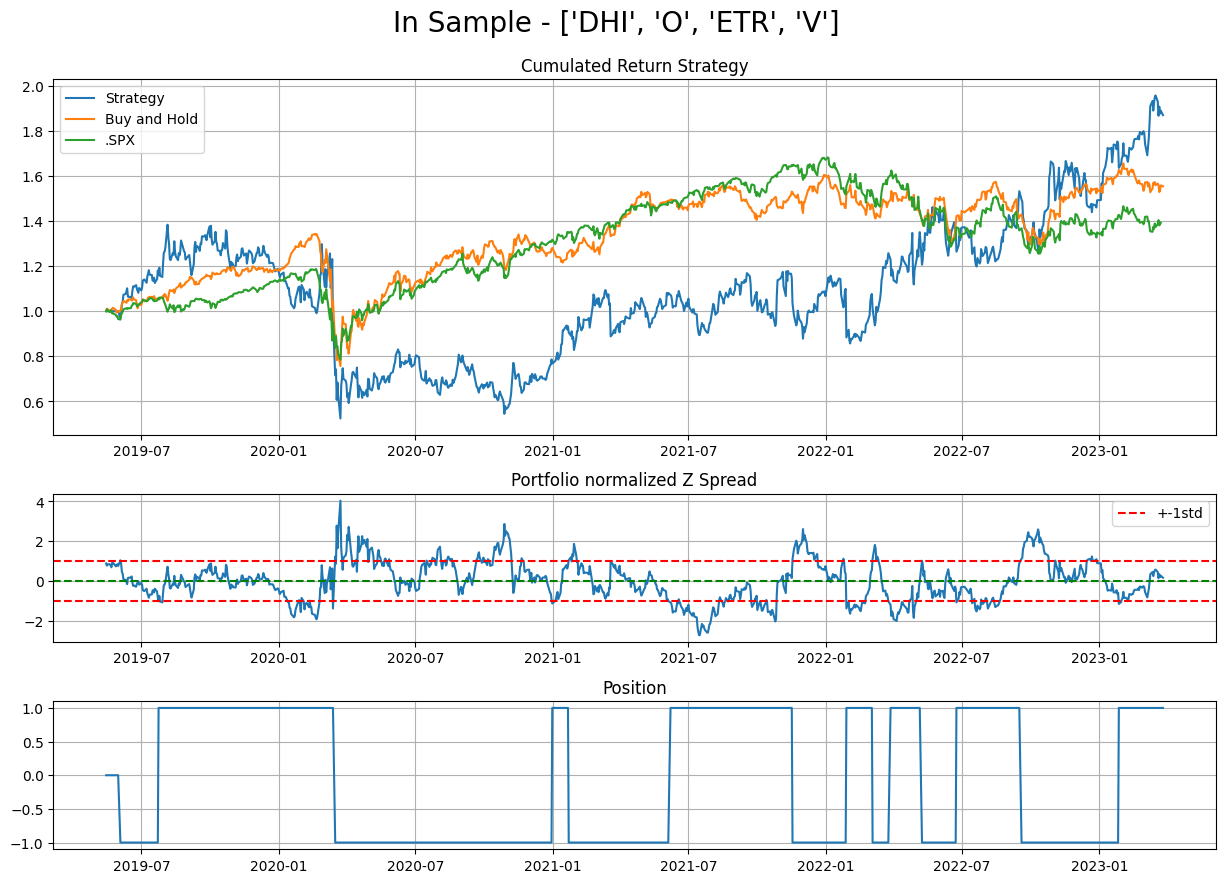

,strategy,cumulative_return,annualized_return,annualized_volatility,annualized_sharpe_ratio,maximum_drawdown
0,Strategy,1.8704,0.3343,0.5825,0.5130,-0.6216
1,SPX,1.3929,0.1132,0.2332,0.3333,-0.3392
2,buy_and_hold,1.5544,0.1534,0.2779,0.4245,-0.4362


[*********************100%***********************]  1 of 1 completed


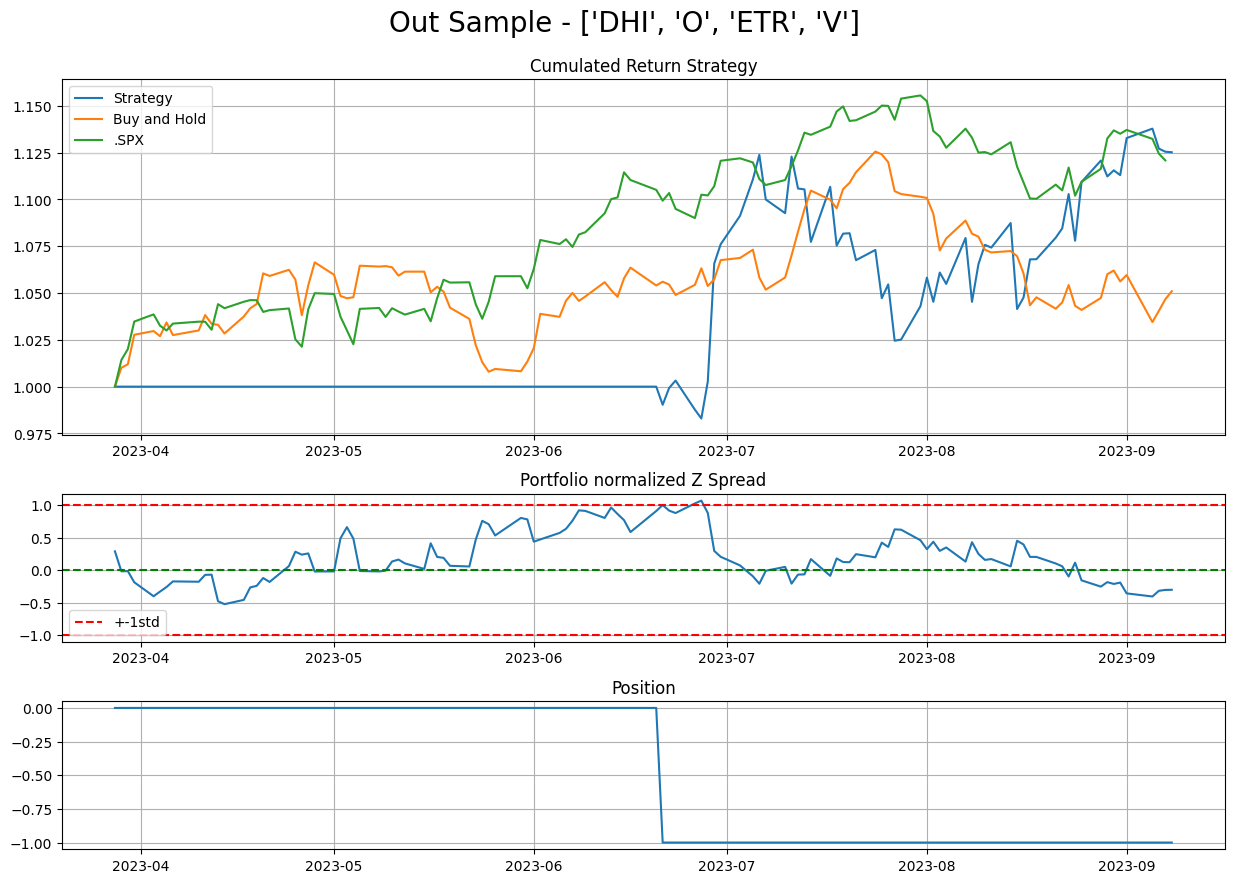

,strategy,cumulative_return,annualized_return,annualized_volatility,annualized_sharpe_ratio,maximum_drawdown
0,Strategy,1.1252,0.2812,0.2018,1.2175,-0.0883
1,SPX,1.1208,0.2610,0.1136,1.9849,-0.0478
2,buy_and_hold,1.0510,0.1176,0.1238,0.6630,-0.0809


[*********************100%***********************]  1 of 1 completed


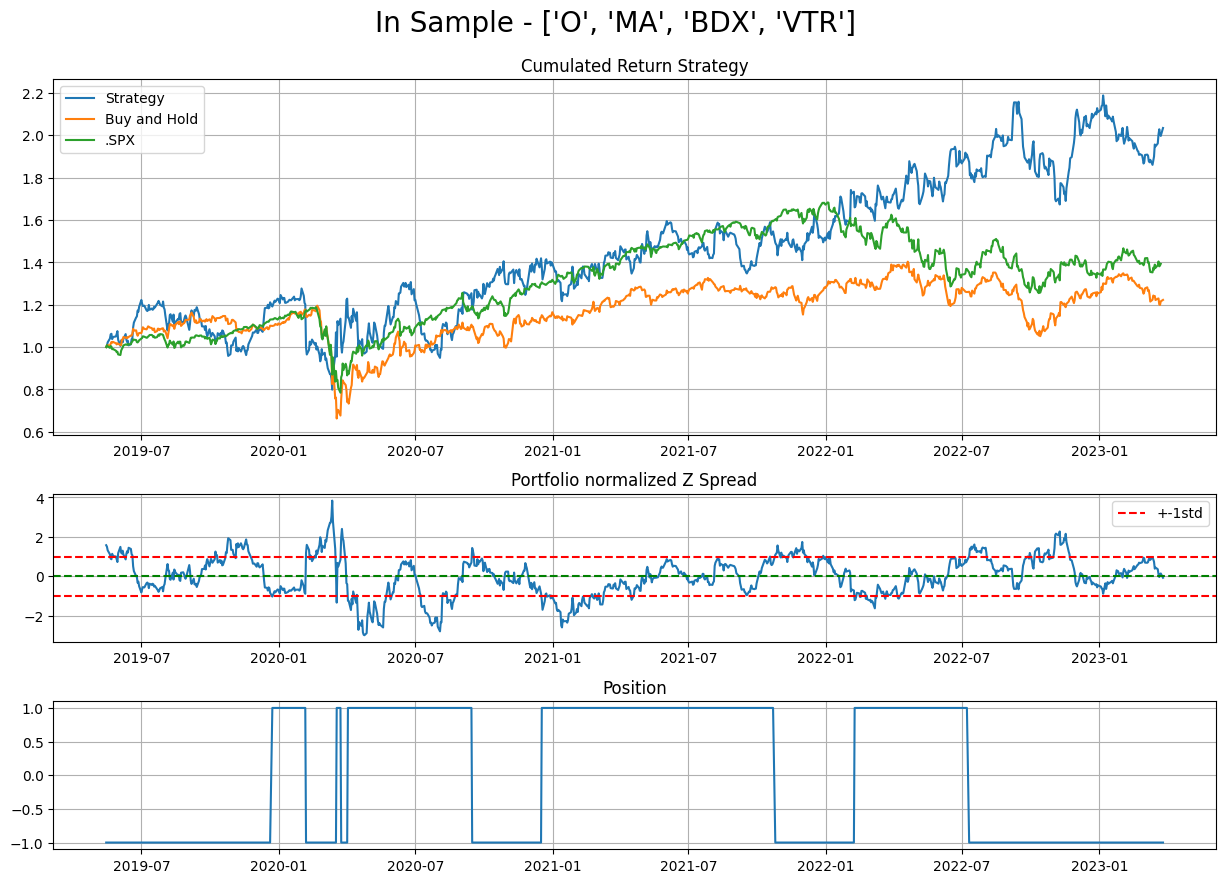

,strategy,cumulative_return,annualized_return,annualized_volatility,annualized_sharpe_ratio,maximum_drawdown
0,Strategy,2.0335,0.2580,0.3859,0.5766,-0.3739
1,SPX,1.3929,0.1132,0.2332,0.3333,-0.3392
2,buy_and_hold,1.2226,0.0918,0.2801,0.2013,-0.4453


[*********************100%***********************]  1 of 1 completed


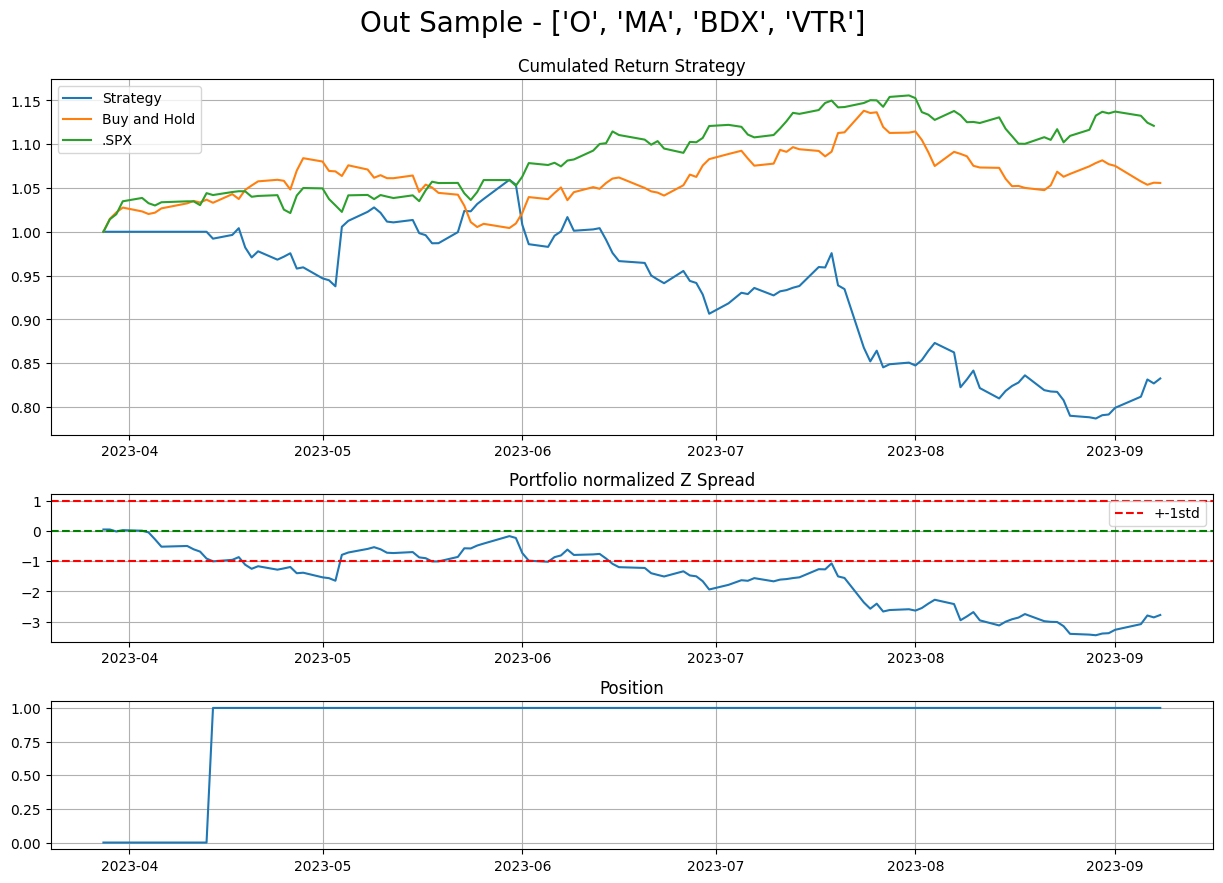

,strategy,cumulative_return,annualized_return,annualized_volatility,annualized_sharpe_ratio,maximum_drawdown
0,Strategy,0.8326,-0.3731,0.2502,-1.6332,-0.2571
1,SPX,1.1208,0.2610,0.1136,1.9849,-0.0478
2,buy_and_hold,1.0557,0.1281,0.1289,0.7187,-0.0796


In [642]:
z_th = 1
for port in ports:
    backtest_portfolios(df_close_train, df_close_test, port, z_th, True)
    backtest_portfolios(df_close_train, df_close_test, port, z_th, False)

# Rolling portfolios
- Using last n days data to re-compute the weights via Johenson's Test
- that's better to capture the cointegration relationship as it might vary over time

In [ ]:
def find_cointegrated_port(df_close, n, iter=100000):    
    print(f'finding cointegrated portfolios of {n} stocks......')
    ports = []    
    tickers = list(df_close.columns)

    while len(ports) < iter:
        port = random.sample(tickers, n)
        ports.append(port)

    ports_coint = []
    ports_coint_vec = []
    with tqdm(total=len(ports)) as pbar:
        for port in ports:
            px = df_close[port].values
            try:
                res = coint_johansen(np.log(px), det_order=0, k_ar_diff=1)
            except:
                # Error: SVD did not converge
                pbar.update(1)
                continue

            # 95% confidence
            if sum(res.lr2 > res.cvm[:,-2]) == n:            
                ports_coint.append(port)
                ports_coint_vec.append(res.evec[:,0])
                print(f'#{len(ports_coint)}: {ports_coint[-1]}')
            pbar.update(1)  

    return list(zip(ports_coint, ports_coint_vec))

def generate_signals(spread_z, z_th):
    signals = []    
    for i, z in enumerate(spread_z):         
        prev_signal = signals[-1] if len(signals) else 0
        if z < -z_th:
            signals.append(1)
        elif z > z_th:
            signals.append(-1)
        #elif z > 0 and prev_signal == 1:
        #    signals.append(0)
        #elif z < 0 and prev_signal == -1:
        #    signals.append(0)
        else:
            signals.append(prev_signal)
    return signals

def backtest_portfolios(df_close_train, df_close_test, port, z_th, in_sample=False):
    port_tickers, ev = port
    weights = ev / np.sum(ev[ev > 0])

    # spread_train = (np.log(df_close_train[port_tickers]) * weights).sum(axis=1)    
    # spread_mean = np.mean(spread_train)
    # spread_std = np.std(spread_train)
    # spread_z_train = (spread_train - spread_mean)/spread_std

    # spread_test = (np.log(df_close_test[port_tickers]) * weights).sum(axis=1)
    # spread_z_test = (spread_test - spread_mean)/spread_std

    # backtesting training data (look-ahead bias)
    if in_sample:
        df = df_close_train
    else:
        df = df_close_test

        

    

        

    signals = generate_signals(spread_z, z_th)
    positions = np.array([s * weights for s in signals])

    px_return = df_close_test[port_tickers].pct_change().fillna(0)
    dates = df_close_test.index
    port_return = (positions * px_return).sum(axis=1)
    port_return_cum = performance.cumulative_return(port_return)

    # summarize the performance
    fig = plt.figure(figsize=(15,10))
    fig.subplots_adjust(hspace=0.4)
    fig.suptitle(f'{"In Sample" if in_sample else "Out Sample"} - {port_tickers}', y=0.95, fontsize=20)

    gs = GridSpec(4,1)

    ax = fig.add_subplot(gs[0:2])
    ax.plot(port_return_cum, label='Strategy')
    ax.set_title('Cumulated Return Strategy')
    ax.grid()

    # buy and hold as benchmark the portfolios
    buy_and_hold_return = px_return.mean(axis=1)
    buy_and_hold_return_cum = performance.cumulative_return(buy_and_hold_return)
    ax.plot(buy_and_hold_return_cum, label='Buy and Hold')

    # .SPX
    spx = yf.download(
        tickers='^SPX', 
        start=min(df_close_test.index), 
        end=max(df_close_test.index), 
        interval="1d",auto_adjust=True).reset_index()
    spx = spx.set_index('Date')
    spx = spx['Close']
    spx_return = spx.pct_change().fillna(0)
    spx_return_cum = performance.cumulative_return(spx_return)
    ax.plot(spx_return_cum, label='.SPX')
    ax.legend(loc='upper left')

    ax = fig.add_subplot(gs[2])
    ax.plot(spread_z_test)
    ax.set_title('Portfolio normalized Z Spread')
    ax.axhline(0, color='green', linestyle='--')
    ax.axhline(z_th, label=f"+-{z_th}std", color='red', linestyle='--')
    ax.axhline(-z_th, color='red', linestyle='--')
    ax.grid()
    ax.legend()

    ax = fig.add_subplot(gs[3])
    ax.plot(dates, signals)
    ax.set_title('Position')
    ax.grid()
    plt.show()

    strat_perf = performance.performance_summary(port_return, 'Strategy')
    spx_perf = performance.performance_summary(spx_return, 'SPX')
    buy_and_hold = performance.performance_summary(buy_and_hold_return, 'buy_and_hold')

    summary = pd.DataFrame([strat_perf, spx_perf, buy_and_hold])
    display(summary)  